Based on:
https://medium.com/@alexppppp/how-to-train-a-custom-keypoint-detection-model-with-pytorch-d9af90e111da
https://github.com/alexppppp/keypoint_rcnn_training_pytorch


In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from google.colab import drive

drive.mount('/content/drive')
!cp drive/MyDrive/ZPS/RESNET/*.py /content
!pip install transforms
!pip install sgmllib3k

Mounted at /content/drive
  Preparing metadata (setup.py) ... done
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=2d0dab2b751c679d2623c7976a56257883a9f219b1bd2af8fadcee06dedc6fae
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


In [ ]:
import os
class WawtpcKeypointsDataset(torch.utils.data.Dataset):
    """return keypoint in format required by the keypoint detector"""
    def __init__(self, data_dir):
        self.data_dir = Path(data_dir)
    def __getitem__(self, idx):
        img = torch.tensor(np.load(self.data_dir / f'img_{idx}.npy').astype(np.float32)).unsqueeze(0).repeat(3, 1, 1)
        points = np.load(self.data_dir / f't_{idx}.npy')
        target = {
            'image_id': torch.tensor([idx]), # for coco evaluation
            "iscrowd": torch.zeros(1, dtype=torch.int64), # for coco evaluatio
            'boxes': torch.tensor([[points[::2].min(), points[1::2].min(), points[::2].max(), points[1::2].max()]]).float(), # boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.
            'labels': torch.tensor([1]).long(), # labels (Int64Tensor[N]): the class label for each ground-truth box
            'keypoints': torch.tensor([[
                [points[0], points[1], 1],
                [points[2], points[3], 1],
                [points[4], points[5], 1],
                ]]).float()#keypoints (FloatTensor[N, K, 3]): the K keypoints location for each of the N instances, in the format [x, y, visibility], where visibility=0 means that the keypoint is not visible.

        }

        return img, target
    def __len__(self):
        lst = os.listdir(self.data_dir) # your directory path
        return len(lst) // 2

In [ ]:
train_dir = Path('drive/MyDrive/ZPS/RESNET/Data/Train/')
test_dir = Path('drive/MyDrive/ZPS/RESNET/Data/Test/')
ds_train = WawtpcKeypointsDataset(train_dir)
ds_test = WawtpcKeypointsDataset(test_dir)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

batch_size = 8
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, pin_memory=False, collate_fn=collate_fn)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=False, pin_memory=False, collate_fn=collate_fn)

In [ ]:
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=3,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   )

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

In [ ]:
from engine import train_one_epoch, evaluate

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device);

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
num_epochs = 5

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, dl_train, device, epoch, print_freq=5)
    lr_scheduler.step()
    try:
        evaluate(model, dl_test, device)
    except:
        print('EVALUATION FAILED')

    # Save model weights after training
    torch.save(model.state_dict(), f'wawtpc_{epoch}.pth')

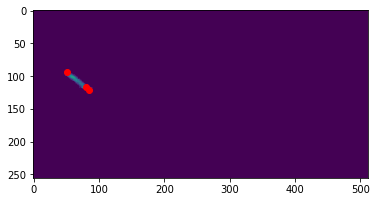

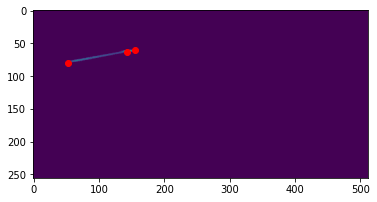

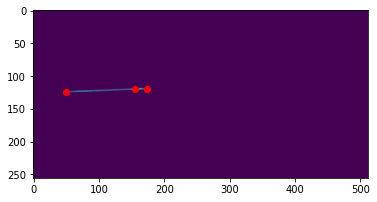

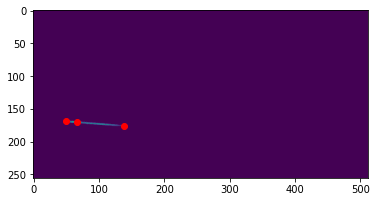

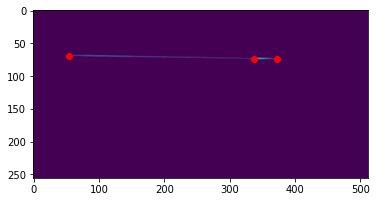

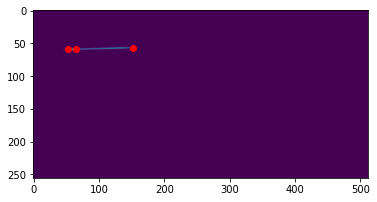

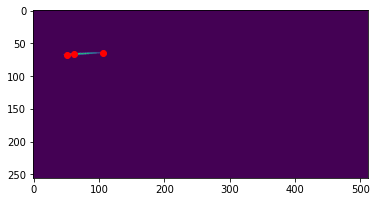

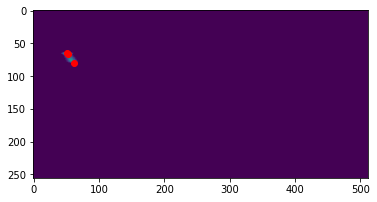

In [ ]:
model.eval();
batch = next(iter(dl_test))
with torch.no_grad():
    preds = model([x.to(device) for x in batch[0]])

for i in range(len(batch[0])):
    plt.figure()
    plt.imshow(batch[0][i][0])
    if len(preds[i]['keypoints']) >0:
        keypoints = preds[i]['keypoints'][0].cpu()
        plt.scatter(keypoints[:,0], keypoints[:,1], c='r')
    plt.savefig(f'wawtpc_epoch_{epoch}_{i}.png', dpi=300)
model.train();


In [ ]:
model.eval();
i = 0
for batch in dl_test:
    with torch.no_grad():
        preds = model([x.to(device) for x in batch[0]])
    for j in range(len(batch[0])):
        i += 1
        plt.figure()
        plt.imshow(batch[0][j][0])
        if len(preds[j]['keypoints']) >0:
            keypoints = preds[j]['keypoints'][0].cpu()
            plt.scatter(keypoints[:,0], keypoints[:,1], c=['r', 'g', 'b'], marker='x')
        plt.savefig(f'evaluation/val_set/wawtpc_epoch_{epoch}_{i}.png', dpi=300)
        plt.close('all')
    if i>100:
        break
model.train();


In [ ]:
file_list[0]

'9877_Y'

In [ ]:
import pandas as pd
import more_itertools
import datetime

In [ ]:
model.load_state_dict(torch.load('wawtpc_4.pth'))

<All keys matched successfully>

In [ ]:
files_for_prediction = file_list[N_train:]
prediction_batch = 16

model.eval();
results = []

t0 = datetime.datetime.now()
for files_batch in more_itertools.batched(files_for_prediction, prediction_batch):
    batch_img = []
    batch_target = []
    batch_info = []

    for file_stem in files_batch:
        batch_info.append(file_stem.split('_'))
        batch_img.append(torch.tensor(np.load(data_dir / f'{file_stem}.npy')).unsqueeze(0).repeat(3, 1, 1))
        batch_target.append(np.loadtxt(data_dir / f'{file_stem}.txt'))

    with torch.no_grad():
        batch_preds = model(torch.stack(batch_img).to(device))

    for info, target, preds in zip(batch_info, batch_target, batch_preds):
        entry = {'file_id': info[0], 'projection': info[1]}
        entry['GT_x1'] = float(target[0])
        entry['GT_y1'] = float(target[1])
        entry['GT_x2'] = float(target[2])
        entry['GT_y2'] = float(target[3])
        entry['GT_x3'] = float(target[4])
        entry['GT_y3'] = float(target[5])

        if len(preds['keypoints']) > 0:
            keypoints = preds['keypoints'][0].cpu().numpy()
            entry['pred_x1'] = float(keypoints[0, 0])
            entry['pred_y1'] = float(keypoints[0, 1])
            entry['pred_x2'] = float(keypoints[1, 0])
            entry['pred_y2'] = float(keypoints[1, 1])
            entry['pred_x3'] = float(keypoints[2, 0])
            entry['pred_y3'] = float(keypoints[2, 1])

        results.append(entry)
    # break

print(f' average time: {len(results) / (datetime.datetime.now() - t0).total_seconds():0.2f} items/s')
model.train();


/home/mbuk/miniconda3/envs/keyflash/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


 average time: 12.30 items/s


In [ ]:
len(results)

9018

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv('evaluation/val_set.csv', index=False)

In [ ]:
results_df = pd.read_csv('evaluation/val_set.csv')

In [ ]:
results_df.keys()

Index(['file_id', 'projection', 'GT_x1', 'GT_y1', 'GT_x2', 'GT_y2', 'GT_x3',
       'GT_y3', 'pred_x1', 'pred_y1', 'pred_x2', 'pred_y2', 'pred_x3',
       'pred_y3'],
      dtype='object')

In [ ]:
results_df.head()

,file_id,projection,GT_x1,GT_y1,GT_x2,GT_y2,GT_x3,GT_y3,pred_x1,pred_y1,pred_x2,pred_y2,pred_x3,pred_y3
0,5020,Y,150.532998,131.110432,51.100000,171.059374,163.303570,125.607185,150.705872,131.114044,50.486004,171.072632,164.913284,124.198143
1,8670,X,124.381245,72.081953,51.100000,70.932649,142.025215,72.358671,123.754128,72.005074,52.059254,70.923698,141.006912,72.365532
2,9899,Z,66.804896,117.963832,199.982367,75.592167,51.100000,122.610405,66.498352,118.368423,202.406128,74.650742,50.373699,122.586784
3,2049,Z,69.021239,153.966606,51.100000,185.305498,71.491299,149.338656,69.269920,154.002167,50.572430,186.273651,71.940994,149.007767
4,9583,Y,55.001021,110.847048,83.344909,147.596927,51.100000,105.455230,54.955322,110.766281,82.585098,147.944016,50.734104,104.633881


In [ ]:
errors = \
    results_df[['GT_x1', 'GT_y1', 'GT_x2', 'GT_y2', 'GT_x3', 'GT_y3']].to_numpy() - \
    results_df[['pred_x1', 'pred_y1', 'pred_x2', 'pred_y2', 'pred_x3', 'pred_y3']].to_numpy()

In [ ]:
errors

array([[-1.72873865e-01, -3.61215684e-03,  6.13996124e-01,
        -1.32574883e-02, -1.60971401e+00,  1.40904228e+00],
       [ 6.27117917e-01,  7.68794787e-02, -9.59253693e-01,
         8.95040666e-03,  1.01830243e+00, -6.86139236e-03],
       [ 3.06544034e-01, -4.04591061e-01, -2.42376107e+00,
         9.41425782e-01,  7.26300812e-01,  2.36203226e-02],
       ...,
       [-4.39330209e-01,  5.76649569e-03, -1.81530088e+00,
        -4.78693048e-01,  6.54523468e-01,  1.92698916e-01],
       [-1.50450993e-01,  1.10046124e-01,  4.01597311e+00,
        -3.13993395e-01,  8.86548615e-01, -3.48003478e-01],
       [ 9.04420165e-02, -3.13912741e-01, -2.14282108e-01,
         1.24534849e-01, -6.06947327e-01,  3.52435996e-02]])

In [ ]:
print('keypoint1 MAE:',  np.nanmean(np.linalg.norm(errors[:,:2], axis=1)))
print('keypoint2 MAE:',  np.nanmean(np.linalg.norm(errors[:,2:4], axis=1)))
print('keypoint3 MAE:',  np.nanmean(np.linalg.norm(errors[:,4:], axis=1)))

keypoint1 MAE: 0.5249965248628515
keypoint2 MAE: 4.187009285725395
keypoint3 MAE: 1.7870861414413797


In [ ]:
print('keypoint1 MSE:',  np.nanmean(np.linalg.norm(errors[:,:2], axis=1)**2))
print('keypoint2 MSE:',  np.nanmean(np.linalg.norm(errors[:,2:4], axis=1)**2))
print('keypoint3 MSE:',  np.nanmean(np.linalg.norm(errors[:,4:], axis=1)**2))

keypoint1 MSE: 4.804034749624667
keypoint2 MSE: 995.954109250419
keypoint3 MSE: 45.44663529717453


In [ ]:
print(f'keypoint1 missing fraction: {np.any(np.isnan(errors[:,:2]), axis=1).mean():0.4f}')
print(f'keypoint2 missing fraction: {np.any(np.isnan(errors[:,2:4]), axis=1).mean():0.4f}')
print(f'keypoint3 missing fraction: {np.any(np.isnan(errors[:,4:]), axis=1).mean():0.4f}')


keypoint1 missing fraction: 0.0004
keypoint2 missing fraction: 0.0004
keypoint3 missing fraction: 0.0004


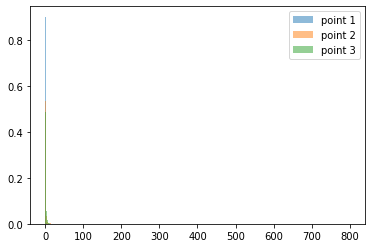

In [ ]:
bins = np.linspace(0, 800, 800)

plt.hist(np.linalg.norm(errors[:,:2], axis=1), bins, density=True, alpha=0.5, label='point 1');
plt.hist(np.linalg.norm(errors[:,2:4], axis=1), bins, density=True, alpha=0.5, label='point 2');
plt.hist(np.linalg.norm(errors[:,4:], axis=1), bins, density=True, alpha=0.5, label='point 3');
plt.legend()

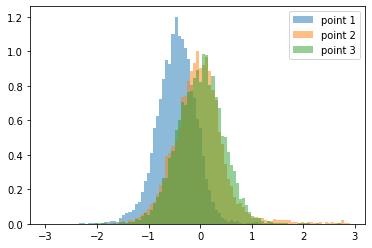

In [ ]:
bins = np.linspace(-3, np.log10(800), 100)

plt.hist(np.log10(np.linalg.norm(errors[:,:2], axis=1)), bins, density=True, alpha=0.5, label='point 1');
plt.hist(np.log10(np.linalg.norm(errors[:,2:4], axis=1)), bins, density=True, alpha=0.5, label='point 2');
plt.hist(np.log10(np.linalg.norm(errors[:,4:], axis=1)), bins, density=True, alpha=0.5, label='point 3');
plt.legend()